In [26]:
%load_ext autoreload
%autoreload 2

import os
from functools import reduce

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from sklearn.preprocessing import MinMaxScaler
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter

sns.set(rc={'figure.figsize':(12, 6)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : False})
pd.set_option('mode.chained_assignment', None)
from src.data.utils import save_to_csv, parallelize_dataframe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dir_path = "/scratch/czestoch/emoji-measures/september-october-twitter-api"
context_free = pd.read_csv(os.path.join("/scratch/czestoch/emoji-measures/", "ambiguity_variation.csv.gz"))[["variation", "emoji"]]
context_vars = pd.read_csv(os.path.join(dir_path, "context_embedds_var.csv.gz"))\
    .rename({"tweet": "context_var", "emojis": "emoji"}, axis=1)
unguessability = pd.read_csv(os.path.join(dir_path, "mean_softmax_entropy.csv.gz"))\
    .rename({"tweet": "unguessability", "emojis": "emoji"}, axis=1)

In [4]:
display(context_free.head())
display(context_vars.head())
display(unguessability.head())

,variation,emoji
0,0.496355,#️⃣
1,0.584016,*️⃣
2,0.276658,©️
3,0.576165,®️
4,0.494922,‼️


,emoji,context_var
0,©️,2.108979
1,®️,2.032928
2,‼️,1.567922
3,™️,1.635136
4,ℹ️,2.302449


,emoji,unguessability
0,©️,4.214310
1,®️,4.238039
2,‼️,3.922030
3,™️,4.553130
4,ℹ️,2.739598


In [5]:
len(context_free), len(context_vars), len(unguessability)

(1325, 501, 499)

In [6]:
dfs = [context_free, context_vars, unguessability]
measures = reduce(lambda left, right: pd.merge(left, right, on='emoji'), dfs)
measures.head()

,variation,emoji,context_var,unguessability
0,0.276658,©️,2.108979,4.214310
1,0.576165,®️,2.032928,4.238039
2,0.494922,‼️,1.567922,3.922030
3,0.272759,™️,1.635136,4.553130
4,0.293363,ℹ️,2.302449,2.739598


In [7]:
measures[measures.isna().any(axis=1)]

,variation,emoji,context_var,unguessability


In [8]:
len(measures)

481

In [9]:
context_free.describe()

,variation
count,1325.000000
mean,0.262528
std,0.164641
min,0.000000
25%,0.128927
50%,0.247732
75%,0.383371
max,0.745275


In [10]:
context_vars.context_var = MinMaxScaler().fit_transform(context_vars.context_var.values.reshape(-1, 1))
unguessability.unguessability = MinMaxScaler().fit_transform(unguessability.unguessability.values.reshape(-1, 1))

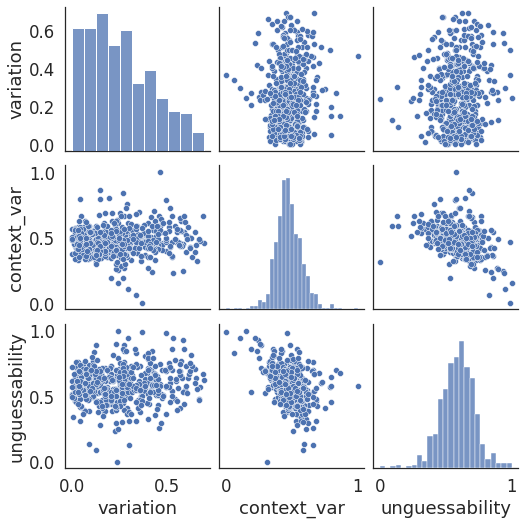

In [11]:
dfs = [context_free, context_vars, unguessability]
measures = reduce(lambda left, right: pd.merge(left, right, on='emoji'), dfs)
sns.pairplot(measures)

In [12]:
from settings import EMOJI_CATEGORIZED
import pickle

with open(EMOJI_CATEGORIZED, "rb") as f:
    categorized = pickle.load(f)

def assign_category(emoji):
    for category in categorized:
        if emoji in categorized[category]:
            return category

measures["category"] = measures.emoji.apply(assign_category)

In [13]:
flags = ['🏳️\u200d🌈',
 '🏴\u200d☠️',
 '🏴\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f',
 '🏴\U000e0067\U000e0062\U000e0073\U000e0063\U000e0074\U000e007f',
 '🏴\U000e0067\U000e0062\U000e0077\U000e006c\U000e0073\U000e007f']

measures = measures[~measures.emoji.isin(flags)]
measures[measures.category == 'flags']

,variation,emoji,context_var,unguessability,category


In [14]:
display(context_free.nlargest(n=10, columns='variation'))
display(context_vars.nlargest(n=10, columns='context_var'))
display(unguessability.nlargest(n=10, columns='unguessability'))

,variation,emoji
1036,0.745275,🛃
1035,0.716157,🛂
652,0.713159,💁
768,0.702734,📵
663,0.700732,💌
1304,0.698550,🧻
1260,0.694345,🧐
155,0.692479,➿
105,0.692086,⛎
617,0.689072,👩‍💼


,emoji,context_var
133,❇️,1.000000
142,➕,0.863563
20,⏰,0.839405
317,🎞️,0.799868
411,🏷️,0.797025
445,🐟,0.796094
80,⚠️,0.787913
124,✒️,0.787577
4,ℹ️,0.754523
143,➖,0.726378


,emoji,unguessability
166,🈹,1.000000
159,🈚,0.989813
253,🍘,0.985300
164,🈶,0.946028
168,🉑,0.942449
157,🈁,0.930574
163,🈵,0.898094
245,🍐,0.895708
160,🈲,0.891362
391,🏣,0.863830


In [15]:
display(context_free.nsmallest(n=10, columns='variation'))
display(context_vars.nsmallest(n=10, columns='context_var'))
display(unguessability.nsmallest(n=10, columns='unguessability'))

,variation,emoji
209,0.0,🌈
277,0.0,🍎
326,0.0,🍿
448,0.0,🐄
474,0.0,🐝
492,0.0,🐯
533,0.0,👗
573,0.0,👨‍👩‍👦
575,0.0,👨‍👩‍👧
576,0.0,👨‍👩‍👧‍👦


,emoji,context_var
160,🈚,0.000000
65,♣️,0.062648
165,🈶,0.106083
167,🈹,0.151842
162,🈳,0.191338
296,🎂,0.192847
169,🉑,0.225803
163,🈴,0.237855
158,🈁,0.247387
19,⏯️,0.249784


,emoji,unguessability
302,🎉,0.000000
144,➡️,0.088782
484,👉,0.131776
28,▶️,0.138265
73,⚓,0.235168
148,⤵️,0.249968
10,↙️,0.258794
482,👇,0.283822
313,🎗️,0.298944
75,⚖️,0.299316


In [18]:
display(unguessability.nsmallest(n=20, columns='unguessability'))

,emoji,unguessability
249,👇,0.000000
253,👋,0.012052
15,☘️,0.039638
455,🚨,0.109904
63,⬇️,0.119649
55,❓,0.127225
19,☮️,0.130324
241,🐾,0.132061
350,🔙,0.145339
469,🤔,0.145692


In [16]:
context_free[context_free.emoji == '↘️'].emoji

12    ↘️
Name: emoji, dtype: object

In [17]:
context_free[context_free.emoji == '↗️']

,variation,emoji
11,0.41467,↗️


In [18]:
# from src.visualization.emoji_plotting import get_emoji
# get_emoji('↗️', log=True, cluster=True)

In [27]:
measures[['context_var', 'variation']].corr('spearman').values[0][1]

-0.060515181882820505

/scratch/czestoch/emoji_imgs/ℹ️.png not found
/scratch/czestoch/emoji_imgs/↔️.png not found
/scratch/czestoch/emoji_imgs/↖️.png not found
/scratch/czestoch/emoji_imgs/↙️.png not found
/scratch/czestoch/emoji_imgs/↩️.png not found
/scratch/czestoch/emoji_imgs/↪️.png not found
/scratch/czestoch/emoji_imgs/⏭️.png not found
/scratch/czestoch/emoji_imgs/⏯️.png not found
/scratch/czestoch/emoji_imgs/⏱️.png not found
/scratch/czestoch/emoji_imgs/⏲️.png not found
/scratch/czestoch/emoji_imgs/⏸️.png not found
/scratch/czestoch/emoji_imgs/⏹️.png not found
/scratch/czestoch/emoji_imgs/⏺️.png not found
/scratch/czestoch/emoji_imgs/Ⓜ️.png not found
/scratch/czestoch/emoji_imgs/☃️.png not found
/scratch/czestoch/emoji_imgs/☣️.png not found
/scratch/czestoch/emoji_imgs/☦️.png not found
/scratch/czestoch/emoji_imgs/☯️.png not found
/scratch/czestoch/emoji_imgs/☸️.png not found
/scratch/czestoch/emoji_imgs/♟️.png not found
/scratch/czestoch/emoji_imgs/♣️.png not found
/scratch/czestoch/emoji_imgs/♦️.pn

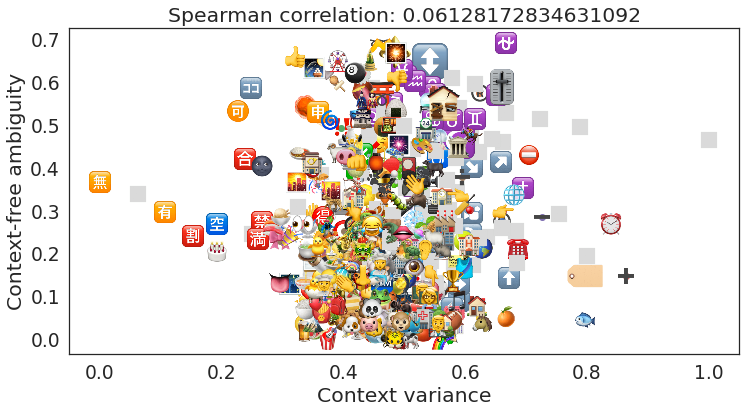

In [27]:
fig, ax = plt.subplots()
for x, y, emoji in zip(measures['context_var'], measures['variation'], measures['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Context variance")
ax.set_ylabel("Context-free ambiguity")
ax.set_title(f"Spearman correlation: {measures[['context_var', 'variation']].corr('spearman').values[0][1]}");

/scratch/czestoch/emoji_imgs/ℹ️.png not found
/scratch/czestoch/emoji_imgs/↔️.png not found
/scratch/czestoch/emoji_imgs/↖️.png not found
/scratch/czestoch/emoji_imgs/↙️.png not found
/scratch/czestoch/emoji_imgs/↩️.png not found
/scratch/czestoch/emoji_imgs/↪️.png not found
/scratch/czestoch/emoji_imgs/⏭️.png not found
/scratch/czestoch/emoji_imgs/⏯️.png not found
/scratch/czestoch/emoji_imgs/⏱️.png not found
/scratch/czestoch/emoji_imgs/⏲️.png not found
/scratch/czestoch/emoji_imgs/⏸️.png not found
/scratch/czestoch/emoji_imgs/⏹️.png not found
/scratch/czestoch/emoji_imgs/⏺️.png not found
/scratch/czestoch/emoji_imgs/Ⓜ️.png not found
/scratch/czestoch/emoji_imgs/☃️.png not found
/scratch/czestoch/emoji_imgs/☣️.png not found
/scratch/czestoch/emoji_imgs/☦️.png not found
/scratch/czestoch/emoji_imgs/☯️.png not found
/scratch/czestoch/emoji_imgs/☸️.png not found
/scratch/czestoch/emoji_imgs/♟️.png not found
/scratch/czestoch/emoji_imgs/♣️.png not found
/scratch/czestoch/emoji_imgs/♦️.pn

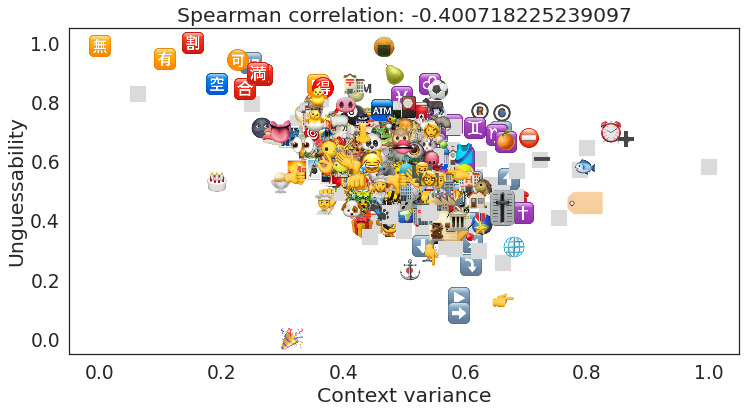

In [28]:
fig, ax = plt.subplots()
for x, y, emoji in zip(measures['context_var'], measures['unguessability'], measures['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Context variance")
ax.set_ylabel("Unguessability")
ax.set_title(f"Spearman correlation: {measures[['context_var', 'unguessability']].corr('spearman').values[0][1]}");

/scratch/czestoch/emoji_imgs/ℹ️.png not found
/scratch/czestoch/emoji_imgs/↔️.png not found
/scratch/czestoch/emoji_imgs/↖️.png not found
/scratch/czestoch/emoji_imgs/↙️.png not found
/scratch/czestoch/emoji_imgs/↩️.png not found
/scratch/czestoch/emoji_imgs/↪️.png not found
/scratch/czestoch/emoji_imgs/⏭️.png not found
/scratch/czestoch/emoji_imgs/⏯️.png not found
/scratch/czestoch/emoji_imgs/⏱️.png not found
/scratch/czestoch/emoji_imgs/⏲️.png not found
/scratch/czestoch/emoji_imgs/⏸️.png not found
/scratch/czestoch/emoji_imgs/⏹️.png not found
/scratch/czestoch/emoji_imgs/⏺️.png not found
/scratch/czestoch/emoji_imgs/Ⓜ️.png not found
/scratch/czestoch/emoji_imgs/☃️.png not found
/scratch/czestoch/emoji_imgs/☣️.png not found
/scratch/czestoch/emoji_imgs/☦️.png not found
/scratch/czestoch/emoji_imgs/☯️.png not found
/scratch/czestoch/emoji_imgs/☸️.png not found
/scratch/czestoch/emoji_imgs/♟️.png not found
/scratch/czestoch/emoji_imgs/♣️.png not found
/scratch/czestoch/emoji_imgs/♦️.pn

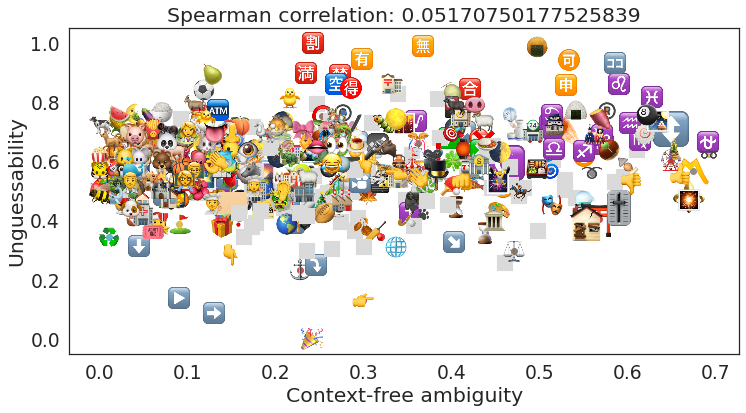

In [29]:
fig, ax = plt.subplots()
for x, y, emoji in zip(measures['variation'], measures['unguessability'], measures['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Context-free ambiguity")
ax.set_ylabel("Unguessability")
ax.set_title(f"Spearman correlation: {measures[['unguessability', 'variation']].corr('spearman').values[0][1]}");

<AxesSubplot:>

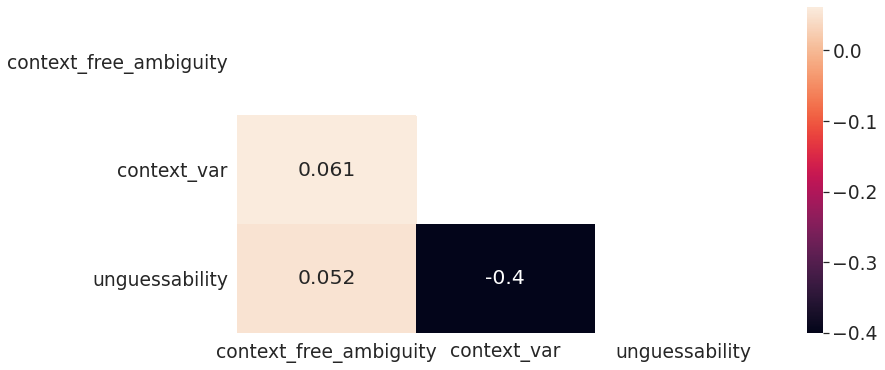

In [30]:
sns.heatmap(measures.rename({"variation": "context_free_ambiguity"}, axis=1).corr('spearman'), annot=True, mask=np.array([[True, True, True], [False, True, True], [False, False, True]]))

In [22]:
from seaborn_qqplot import pplot

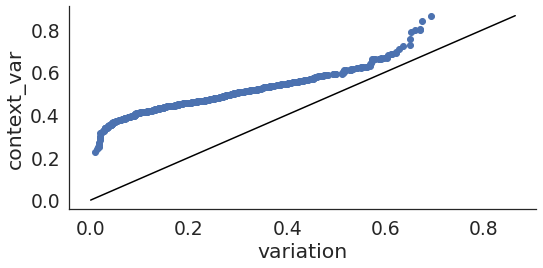

In [31]:
pplot(measures, x="variation", y="context_var", kind='qq',\
      height=4, aspect=2, display_kws={"identity":True});

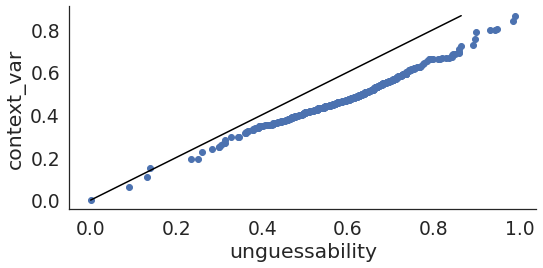

In [32]:
pplot(measures, x="unguessability", y="context_var", kind='qq',\
      height=4, aspect=2, display_kws={"identity":True})

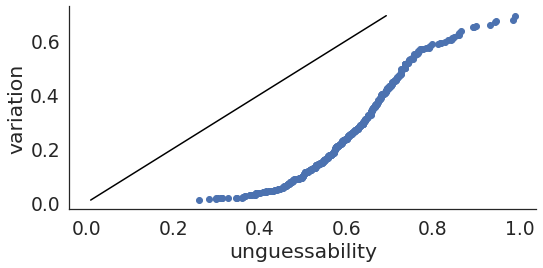

In [33]:
pplot(measures, x="unguessability", y="variation", kind='qq',\
      height=4, aspect=2, display_kws={"identity":True})

In [34]:
measures.describe()

,variation,context_var,unguessability
count,477.000000,477.000000,477.000000
mean,0.254693,0.475536,0.590082
std,0.171462,0.107146,0.133003
min,0.000000,0.000000,0.000000
25%,0.114938,0.415761,0.510630
50%,0.232529,0.466365,0.594313
75%,0.379352,0.536686,0.673176
max,0.692479,1.000000,1.000000


In [18]:
import plotly.express as px
# fig = px.scatter_3d(measures, x='unguessability', y='context_var', z='variation',\
#                     color='category', hover_data=['emoji'])
# fig.show()

In [28]:
# import plotly.express as px
# import pandas as pd
# import plotly.graph_objects as go
# import numpy as np


# # fig = px.scatter_3d(df, x='Functionality ', y='Accessibility', z='Immersion', color='Platforms')
# df = measures
# fig = px.scatter_3d(df, x='unguessability', y='context_var', z='variation',\
#                     color='category', hover_data=['emoji'])

# bright_blue = [[0, '#7DF9FF'], [1, '#7DF9FF']]
# bright_pink = [[0, '#FF007F'], [1, '#FF007F']]
# light_yellow = [[0, '#FFDB58'], [1, '#FFDB58']]

# # need to add starting point of 0 to each dimension so the plane extends all the way out
# zero_pt = pd.Series([0])
# z = zero_pt.append(df['variation'], ignore_index=True).reset_index(drop=True)
# y = zero_pt.append(df['context_var'], ignore_index=True).reset_index(drop=True)
# x = zero_pt.append(df['unguessability'], ignore_index=True).reset_index(drop=True)

# length_data = len(z)
# z_plane_pos = 40*np.ones((length_data,length_data))

# fig.add_trace(go.Surface(x=x, y=y, z=z_plane_pos, colorscale=light_yellow,  showscale=False))
# fig.add_trace(go.Surface(x=x.apply(lambda x: 10), y=y, z = np.array([z]*length_data), colorscale= bright_blue, showscale=False))
# fig.add_trace(go.Surface(x=x, y= y.apply(lambda x: 30), z =  np.array([z]*length_data).transpose(), colorscale=bright_pink, showscale=False))
# fig.show()

In [27]:
# save_to_csv(measures, '/scratch/czestoch/emoji-measures/september_all_measures.csv')

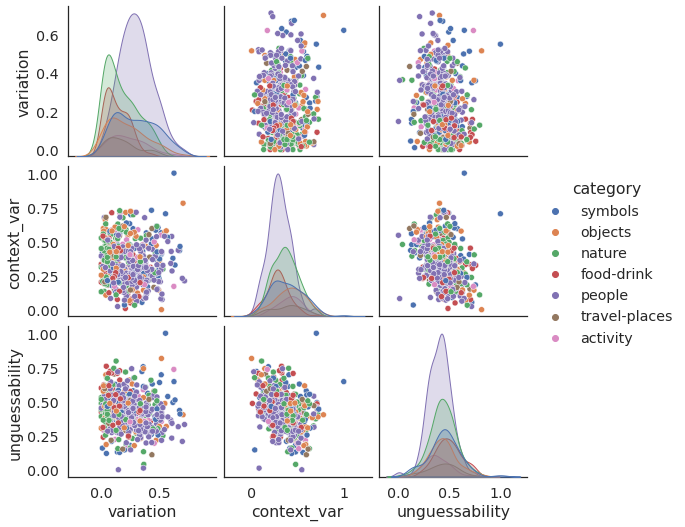

In [23]:
sns.pairplot(measures[measures.category != 'flags'], hue='category')

In [50]:
measures.groupby("category").emoji.count().sort_values()

category
travel-places     23
activity          31
objects           57
food-drink        59
symbols           76
nature           112
people           184
Name: emoji, dtype: int64

<AxesSubplot:xlabel='category', ylabel='variation'>

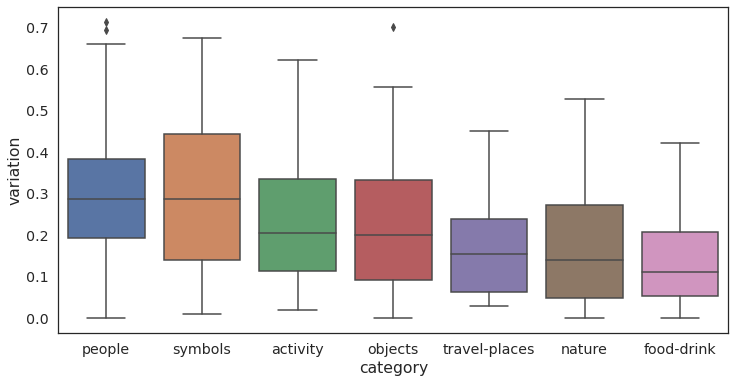

In [45]:
df = measures[["variation", "category"]]
sorted_index = df.groupby("category").median().sort_values("variation", ascending=False).index
sns.boxplot(data=df, x="category", y="variation", order=sorted_index)

<AxesSubplot:xlabel='category', ylabel='context_var'>

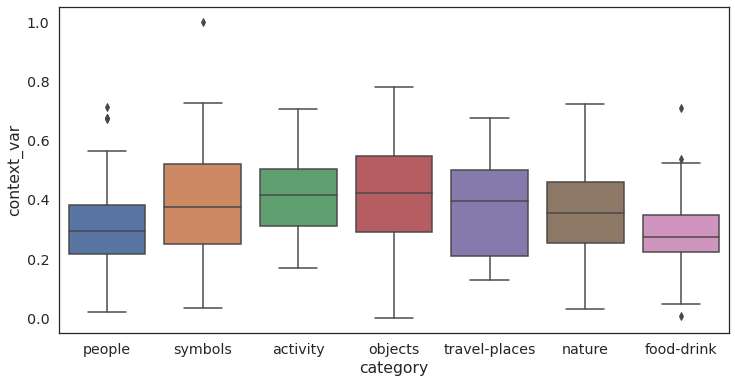

In [46]:
df = measures[["context_var", "category"]]
# sorted_index = df.groupby("category").median().sort_values("context_var", ascending=False).index
sns.boxplot(data=df, x="category", y="context_var", order=sorted_index)

<AxesSubplot:xlabel='category', ylabel='unguessability'>

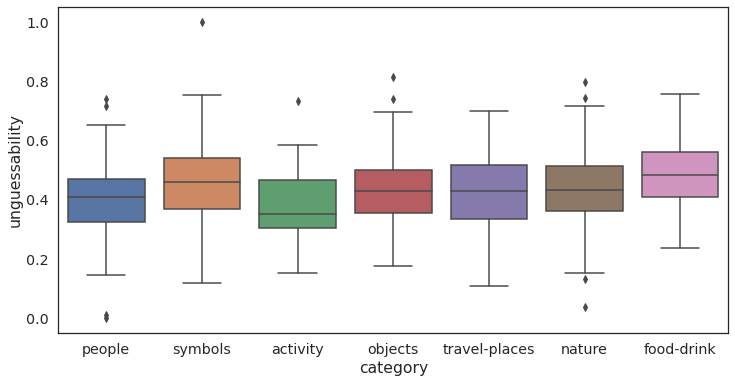

In [47]:
df = measures[["unguessability", "category"]]
# sorted_index = df.groupby("category").median().sort_values("unguessability", ascending=False).index
sns.boxplot(data=df, x="category", y="unguessability", order=sorted_index)

In [57]:
measures

,variation,emoji,context_var,unguessability,category
0,0.276658,©️,0.708219,0.491838,symbols
1,0.494922,‼️,0.228792,0.450096,symbols
2,0.487782,⁉️,0.248033,0.379331,symbols
3,0.272759,™️,0.593024,0.578358,symbols
4,0.093595,⌚,0.265284,0.520986,objects
...,...,...,...,...,...
542,0.129710,🧬,0.424507,0.430411,objects
543,0.073671,🧱,0.421342,0.485465,objects
544,0.197647,🧸,0.608683,0.306835,objects
545,0.230861,🧹,0.470045,0.488601,objects


<AxesSubplot:xlabel='category', ylabel='value'>

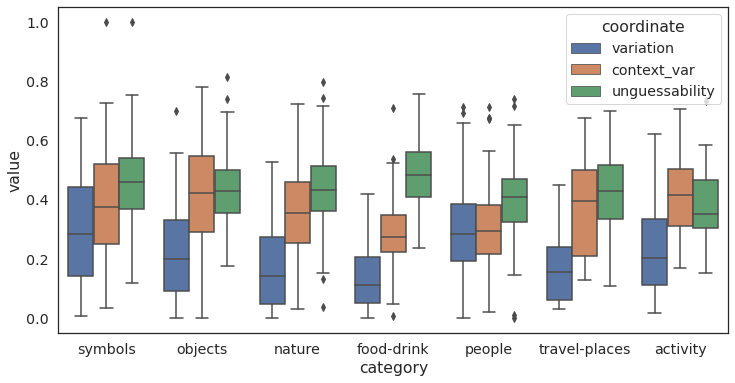

In [61]:
melted = pd.melt(measures, id_vars=['emoji', 'category'], var_name='coordinate', value_name='value')
sns.boxplot(data=melted, x='category', hue='coordinate', y='value')

In [63]:
measures.median()

variation         0.224625
context_var       0.330887
unguessability    0.428358
dtype: float64

In [39]:
variation_median = measures.median().variation
context_var_median = measures.median().context_var
unguessability_median = measures.median().unguessability

first_octant = measures[(measures.variation <= variation_median) & (measures.context_var <= context_var_median)\
                        & (measures.unguessability <= unguessability_median)]

second_octant = measures[(measures.variation <= variation_median) & (measures.context_var <= context_var_median)\
                         & (measures.unguessability > unguessability_median)]

third_octant = measures[(measures.variation <= variation_median) & (measures.context_var > context_var_median)\
                        & (measures.unguessability <= unguessability_median)]

fourth_octant = measures[(measures.variation > variation_median) & (measures.context_var <= context_var_median)\
                         & (measures.unguessability <= unguessability_median)]

fifth_octant = measures[(measures.variation > variation_median) & (measures.context_var > context_var_median)\
                        & (measures.unguessability > unguessability_median)]

sixth_octant = measures[(measures.variation <= variation_median) & (measures.context_var > context_var_median)\
                        & (measures.unguessability > unguessability_median)]

seventh_octant = measures[(measures.variation > variation_median) & (measures.context_var > context_var_median)\
                          & (measures.unguessability <= unguessability_median)]

eigth_octant = measures[(measures.variation > variation_median) & (measures.context_var <= context_var_median)\
                        & (measures.unguessability > unguessability_median)]

octants = [first_octant, second_octant, third_octant, fourth_octant, \
          fifth_octant, sixth_octant, seventh_octant, eigth_octant]

In [45]:
for octant in octants:
    display(octant.category.value_counts())
    display(octant.emoji.values)
    print()

people           11
food-drink        8
nature            6
symbols           4
activity          2
objects           2
travel-places     1
Name: category, dtype: int64

array(['☀️', '☕', '♥️', '🌄', '🌊', '🌝', '🍆', '🍔', '🍕', '🍫', '🍵', '🍷', '🎲',
       '🎶', '🏀', '🐙', '🐶', '🐷', '👁️', '👃', '👏', '💙', '🔐', '🔑', '🔙', '😀',
       '😉', '😞', '😡', '😥', '😭', '🙁', '🚶', '🥧'], dtype=object)

nature           24
food-drink       24
people           24
symbols          11
objects           7
activity          2
travel-places     2
Name: category, dtype: int64

array(['⌚', '☔', '☹️', '⚾', '⛽', '✊', '❣️', '❤️', '🆗', '🌛', '🌯', '🌷', '🌸',
       '🌺', '🌼', '🍇', '🍌', '🍍', '🍎', '🍏', '🍑', '🍜', '🍞', '🍟', '🍦', '🍩',
       '🍪', '🍭', '🍸', '🍺', '🍼', '🍾', '🎁', '🎂', '🎈', '🐀', '🐈', '🐌', '🐍',
       '🐒', '🐓', '🐕', '🐥', '🐧', '🐯', '🐱', '🐸', '🐻', '🐼', '👅', '👌', '👑',
       '👫', '👸', '👻', '👼', '💍', '💎', '💏', '💐', '💕', '💖', '💛', '💞', '💟',
       '💣', '💤', '🔌', '🔥', '🖤', '😍', '😎', '😘', '😠', '😴', '😻', '🙂', '🚂',
       '🛌', '🤠', '🤡', '🤣', '🤴', '🥁', '🥑', '🥔', '🥛', '🥤', '🥰', '🥶', '🦀',
       '🦋', '🧀', '🧡'], dtype=object)

nature           26
people           16
symbols          11
objects          11
activity          8
travel-places     7
food-drink        5
Name: category, dtype: int64

array(['☮️', '♠️', '♻️', '⚽', '⛳', '✂️', '✌️', '✍️', '✏️', '❓', '➡️',
       '⬆️', '⬇️', '⭐', '🌅', '🌋', '🌍', '🌎', '🌏', '🌟', '🌲', '🌵', '🌹', '🌽',
       '🍅', '🍿', '🎃', '🎵', '🎸', '🎼', '🏆', '🏌️', '🏐', '🏒', '🏡', '🐇', '🐎',
       '🐔', '🐘', '🐝', '🐨', '🐬', '🐮', '🐳', '🐺', '👂', '👇', '👽', '💋', '💓',
       '💩', '💰', '💻', '📖', '📚', '📞', '📷', '📺', '🔒', '🔔', '🗽', '😆', '😇',
       '😔', '😺', '😿', '🙉', '🚀', '🚌', '🚲', '🛑', '🤒', '🤖', '🥞', '🦁', '🦄',
       '🦇', '🦈', '🦊', '🦎', '🦖', '🧁', '🧠', '🧸'], dtype=object)

people           48
nature            9
food-drink        4
symbols           3
activity          2
travel-places     2
objects           1
Name: category, dtype: int64

array(['⁉️', '☄️', '☠️', '✈️', '🆘', '🌌', '🌚', '🌞', '🌿', '🍂', '🍝', '🍴',
       '🎄', '🎯', '👀', '👄', '👊', '👋', '👐', '👓', '👺', '💁', '💅', '💔', '💦',
       '💨', '💼', '📲', '😁', '😂', '😃', '😊', '😌', '😏', '😑', '😒', '😗', '😣',
       '😧', '😨', '😫', '😬', '😸', '😹', '😼', '🙃', '🙄', '🙇', '🙈', '🙌', '🙏',
       '🤓', '🤗', '🤘', '🤙', '🤚', '🤝', '🤞', '🤥', '🤧', '🤬', '🤮', '🤯', '🤲',
       '🥂', '🥃', '🥊', '🥴', '🧐'], dtype=object)

symbols          15
people           13
nature            7
objects           4
travel-places     3
food-drink        2
Name: category, dtype: int64

array(['©️', '™️', '☢️', '♋', '♍', '⚓', '⚜️', '⚠️', '⚡', '⛅', '❌', '🌕',
       '🍗', '🍳', '🎥', '🐑', '👆', '👉', '👟', '👩\u200d❤️\u200d💋\u200d👩', '💀',
       '💥', '💬', '💴', '📈', '🔄', '🔜', '🔞', '🔫', '🔱', '🔵', '😈', '😚', '😢',
       '😤', '😮', '😽', '😾', '🚦', '🚫', '🤪', '🥀', '🦠', '🧹'], dtype=object)

nature           19
food-drink       10
objects          10
people            6
activity          5
travel-places     5
symbols           4
Name: category, dtype: int64

array(['▶️', '☎️', '⚰️', '🌃', '🌈', '🌙', '🌠', '🌮', '🌳', '🌻', '🍄', '🍉', '🍊',
       '🍋', '🍓', '🍯', '🍰', '🎒', '🎣', '🎧', '🎫', '🏃', '🏅', '🏈', '🏠', '🐄',
       '🐅', '🐐', '🐖', '🐜', '🐟', '🐢', '🐣', '🐰', '🐴', '👧', '👶', '💄', '💗',
       '💚', '💜', '💵', '💸', '📱', '📻', '🔨', '🔪', '🚗', '🚘', '🚽', '🤰', '🥚',
       '🥜', '🥩', '🦅', '🦆', '🦉', '🧬', '🧱'], dtype=object)

people           33
objects          14
symbols          13
nature           13
activity          9
travel-places     1
food-drink        1
Name: category, dtype: int64

array(['⏰', '☁️', '☘️', '☺️', '♎', '⚔️', '⚖️', '⚫', '✝️', '✨', '❗', '⤵️',
       '⭕', '🅿️', '🌀', '🌐', '🌱', '🌾', '🍁', '🍃', '🍹', '🎀', '🎓', '🎤', '🎨',
       '🎩', '🎪', '🎭', '🎾', '🏉', '🏏', '🏹', '🐊', '🐦', '🐾', '👈', '👍', '👎',
       '👠', '👣', '👹', '👾', '💊', '💌', '💡', '💫', '💭', '📌', '📢', '📣', '📦',
       '📩', '📸', '🔁', '🔍', '🔮', '🔴', '🕊️', '🖕', '🖖', '🗣️', '😄', '😅', '😐',
       '😕', '😖', '😜', '😟', '😯', '😰', '😱', '😲', '😳', '😶', '🚨', '🤐', '🤔',
       '🤜', '🤦', '🤨', '🤫', '🤷', '🥇', '🧿'], dtype=object)

people           33
symbols          15
objects           8
nature            8
food-drink        5
activity          3
travel-places     2
Name: category, dtype: int64

array(['‼️', '⏳', '☑️', '☝️', '♈', '✅', '✋', '✔️', '❄️', '❕', '🃏', '🅱️',
       '🌴', '🍀', '🍒', '🍣', '🍬', '🍻', '🎉', '🎊', '🎬', '🎮', '🎱', '🐉', '🐽',
       '👿', '💃', '💆', '💉', '💘', '💝', '💢', '💧', '💪', '💯', '📍', '📝', '🔊',
       '🔋', '🔝', '🕺', '🖐️', '🗿', '😋', '😓', '😙', '😛', '😝', '😦', '😩', '😪',
       '😵', '😷', '🙀', '🙅', '🙆', '🙊', '🙋', '🚬', '🚮', '🛫', '🤑', '🤕', '🤟',
       '🤢', '🤤', '🤩', '🤭', '🥘', '🥳', '🥵', '🥺', '🦍', '🧢'], dtype=object)